# Adaptive Stress Testing: Walk1D Example

This notebook expands on the Walk1D example, see the [Walk1D.jl](https://github.com/sisl/POMDPStressTesting.jl/blob/master/test/Walk1D.jl) file for the non-notebook version and [walk1d.pdf](https://github.com/sisl/POMDPStressTesting.jl/blob/master/test/pdf/walk1d.pdf) for the write-up version.

---

## Abstract
In this self-contained tutorial, we define a simple problem for adaptive stress testing (AST)
to find failures. This problem, called Walk1D, samples random walking distances from a standard
normal distribution $\mathcal{N}(0,1)$ and defines failures as walking past a certain threshold
(which is set to ±10 in this example). AST will either select the seed which deterministically
controls the sampled value from the distribution (i.e. from the transition model) or will directly
sample the provided environmental distributions. These action modes are determined by the seed-action or
sample-action options. AST will guide the simulation to failure events using a notion of distance to failure,
while simultaneously trying to find the set of actions that maximizes the log-likelihood of the samples.

In [1]:
using POMDPStressTesting # this package
using Distributions      # for the Normal distribution
using Parameters         # for @with_kw default struct parameters

---
# Gray-box Simulator and Environment
The simulator and environment are treated as gray-box because we need
access to the state-transition distributions and their associated likelihoods.

### Parameters
First, we define the parameters of our simulation.

In [2]:
@with_kw mutable struct Walk1DParams
    startx::Float64  = 0  # Starting x-position
    threshx::Float64 = 10 # +- boundary threshold
    endtime::Int64   = 30 # Simulate end time
end

Walk1DParams

### GrayBox.Simulation
Next, we define a `GrayBox.Simulation` structure which stores simulation-related values.

In [3]:
@with_kw mutable struct Walk1DSim <: GrayBox.Simulation
    params::Walk1DParams = Walk1DParams()     # Parameters
    x::Float64 = 0                            # Current x-position
    t::Int64 = 0                              # Current time ±
    distribution::Distribution = Normal(0, 1) # Transition distribution
end

Walk1DSim

### GrayBox.environment
Then, we define our `GrayBox.Environment` distributions.
When using the `ASTSampleAction`, as opposed to `ASTSeedAction`,
we need to provide access to the sampleable environment.

In [4]:
GrayBox.environment(sim::Walk1DSim) = GrayBox.Environment(:x => sim.distribution)

### GrayBox.transition!
We override the transition function from the `GrayBox` interface,
which takes an environment sample as input. We apply the sample in our simulator,
and return the log-likelihood.

In [5]:
function GrayBox.transition!(sim::Walk1DSim, sample::GrayBox.EnvironmentSample)
    sim.t += 1                  # Keep track of time
    sim.x += sample[:x].value   # Move agent using sampled value from input
    return logpdf(sample)::Real # Summation handled by `logpdf()`
end

---
# Black-box System
The system under test, in this case a simple single-dimensional moving agent,
is always treated as *black-box*. The following interface functions are overridden
to minimally interact with the system, and use outputs from the system to
determine failure event indications and distance metrics.

### BlackBox.initialize!
Now we override the `BlackBox` interface, starting with the
function that initializes the simulation object. Interface functions
ending in `!` may modify the `sim` object in place.

In [6]:
function BlackBox.initialize!(sim::Walk1DSim)
    sim.t = 0
    sim.x = sim.params.startx
end

### BlackBox.distance
We define how close we are to a failure event using a non-negative distance metric.

In [7]:
BlackBox.distance(sim::Walk1DSim) = max(sim.params.threshx - abs(sim.x), 0)

### BlackBox.isevent
We define an indication that a failure event occurred.

In [8]:
BlackBox.isevent(sim::Walk1DSim) = abs(sim.x) >= sim.params.threshx

### BlackBox.isterminal
Similarly, we define an indication that the simulation (or system) is in a terminal state.

In [9]:
BlackBox.isterminal(sim::Walk1DSim) = BlackBox.isevent(sim) || sim.t >= sim.params.endtime

### BlackBox.evaluate!
Lastly, we use our defined interface to evaluate the system under test.
Using the input sample, we return the log-likelihood, distance to an event, and event indication.

In [10]:
function BlackBox.evaluate!(sim::Walk1DSim, sample::GrayBox.EnvironmentSample)
    logprob::Real = GrayBox.transition!(sim, sample) # Step simulation
    d::Real       = BlackBox.distance(sim)           # Calculate miss distance
    event::Bool   = BlackBox.isevent(sim)            # Check event indication
    return (logprob::Real, d::Real, event::Bool)
end

---
# AST Setup and Running
Setting up our simulation, we instantiate our simulation object and
pass that to the Markov decision proccess (MDP) object of the adaptive stress testing
formulation. We use Monte Carlo tree search (MCTS) with progressive widening on the action
space as our solver. Hyperparameters are passed to `MCTSPWSolver`, which is
a simple wrapper around the `POMDPs.jl` implementation of [MCTS.jl](https://github.com/JuliaPOMDP/MCTS.jl). Lastly, we solve the MDP
to produce a `planner`. Note we are using the `ASTSampleAction`.

### Setup/create AST planner
* `planner` is used to play out the search
* `planner.mdp::ASTMDP` is the main MDP problem formulation object for AST (this holds reward metrics)
* `planner.mdp.sim::Walk1DSim` is the main simulation object, holding all simulation information (e.g., current x position, settings for the simulation, etc)
* `solver::MCTSPWSolver` holds solver-specific parameters and is used to generate the `planner`
    * *See below for additional solvers*

In [11]:
function setup_ast(seed=0)
    # Create gray-box simulation object
    sim::GrayBox.Simulation = Walk1DSim()

    # AST MDP formulation object
    mdp::ASTMDP = ASTMDP{ASTSampleAction}(sim)
    mdp.params.debug = true # record metrics
    mdp.params.top_k = 10   # record top k best trajectories
    mdp.params.seed = seed  # set RNG seed for determinism

    # Hyperparameters for MCTS-PW as the solver
    solver = MCTSPWSolver(n_iterations=1000,        # number of algorithm iterations
                          exploration_constant=1.0, # UCT exploration
                          k_action=1.0,             # action widening
                          alpha_action=0.5,         # action widening
                          depth=sim.params.endtime) # tree depth

    # Get online planner (no work done, yet)
    planner = solve(solver, mdp)

    return planner
end

setup_ast (generic function with 2 methods)

### Search
After setup, we *search* for failures using the planner and output the best action trace.

In [12]:
planner = setup_ast();

In [13]:
action_trace = search!(planner)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


10-element Array{ASTAction,1}:
 ASTSampleAction
  sample: Dict{Symbol,POMDPStressTesting.AST.GrayBox.Sample}

 ASTSampleAction
  sample: Dict{Symbol,POMDPStressTesting.AST.GrayBox.Sample}

 ASTSampleAction
  sample: Dict{Symbol,POMDPStressTesting.AST.GrayBox.Sample}

 ASTSampleAction
  sample: Dict{Symbol,POMDPStressTesting.AST.GrayBox.Sample}

 ASTSampleAction
  sample: Dict{Symbol,POMDPStressTesting.AST.GrayBox.Sample}

 ASTSampleAction
  sample: Dict{Symbol,POMDPStressTesting.AST.GrayBox.Sample}

 ASTSampleAction
  sample: Dict{Symbol,POMDPStressTesting.AST.GrayBox.Sample}

 ASTSampleAction
  sample: Dict{Symbol,POMDPStressTesting.AST.GrayBox.Sample}

 ASTSampleAction
  sample: Dict{Symbol,POMDPStressTesting.AST.GrayBox.Sample}

 ASTSampleAction
  sample: Dict{Symbol,POMDPStressTesting.AST.GrayBox.Sample}


### Playback
We can also *playback* specific trajectories and print intermediate $x$-values.

In [14]:
final_state = playback(planner, action_trace, sim->sim.x)

0.0
-0.5308448745957546
-1.5298839185380215
-1.3394607946860835
-2.0660499771772423
-2.2190243202385846
-4.749109676020277
-6.334613088659528
-7.7576203272116455
-8.778690753493658
-10.094490017320119


ASTState
  t_index: Int64 11
  parent: ASTState
  action: ASTSampleAction
  hash: UInt64 0x1868d0c6d252f218
  q_value: Float64 -1.7846023845478027
  terminal: Bool true


### Metrics
Finally, we can print metrics associated with the AST run for further analysis.

In [15]:
failure_rate = print_metrics(planner)

First failure: 382 of 60013
Number of failures: 757
Failure rate: 1.26139%


1.2613933647709663

---
# Visualize interactive MCTS tree (using D3.js)
When using the `MCTSPWSolver`, we can output the tree from the `search!` function and visulize it using `D3Trees.jl`.

In [16]:
d3tree = visualize(planner) # re-runs the search to output the tree, then visualizes it

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


0x6426dea4605cb342
N:   1000

├──x => 0.6791074260357777 (-1.1495319812531424)
│  Q: -47.20
│  N:     26

│  └──       0x750b208b8264ee5e
│     N:     25

│     ├──x => -0.0818509513815898 (-0.9222883223257085)
│     │  Q: -45.44
│     │  N:     12
 (1 children)
│     ├──x => 0.1456142708384867 (-0.9295402911405849)
│     │  Q: -50.20
│     │  N:      2
 (1 children)
│     ├──x => -0.7945657412065438 (-1.2346058917542249)
│     │  Q: -45.48
│     │  N:      9
 (1 children)
│     ├──x => 0.2901285410626145 (-0.9610258183742334)
│     │  Q: -47.01
│     │  N:      1
 (1 children)
│     └──x => 0.39547927310015385 (-0.9971404609305858)
│        Q: -48.13
│        N:      1
 (1 children)
├──x => 0.40838681696170764 (-1.0023284293387305)
│  Q: -51.57
│  N:      2

│  └──       0xd7b746a14545e842
│     N:      1

│     └──x => -1.3719311300410884 (-1.8600360459925818)
│        Q: -56.66
│        N:      1
 (1 children)
├──x => 0.11851788595392865 (-0.925961777850167)
│  Q: -53.98
│  N:      1

│  └──       0x3aa3f93ec53ebb0f
│     N:      0

├──x => -0.9115109252669642 (-1.3343646166451915)
│  Q: -48.94
│  N:      5

│  └──       0xa3fa18d11bb629b6
│     N:      4

│     ├──x => 0.5435481378302569 (-1.0666608222740428)
│     │  Q: -49.58
│     │  N:      3
 (1 children)
│     └──x => -1.208631824600464 (-1.649333976923196)
│        Q: -48.82
│        N:      1
 (1 children)
├──x => -0.5308448745957546 (-1.059836673646964)
│  Q: -27.00
│  N:    935

│  └──       0xf0f4a5f85a1377e1
│     N:    934

│     ├──x => -0.999039043942267 (-1.4179780388652121)
│     │  Q: -24.79
│     │  N:    885
 (1 children)
│     ├──x => -0.6716910867691027 (-1.144522991227202)
│     │  Q: -45.40
│     │  N:      8
 (1 children)
│     ├──x => -1.0040125287502586 (-1.4229591121484173)
│     │  Q: -50.06
│     │  N:      1
 (1 children)
│     ├──x => -0.8855809545448899 (-1.311065346730992)
│     │  Q: -48.93
│     │  N:      1
 (1 children)
│     ├──x => 0.6717550994634951 (-1.144565990032278)
│     │  Q: -50.88
│     │  N:      1
 (1 children)
│     ├──x => 0.49825318178066635 (-1.0430666497819516)
│     │  Q: -46.14
│     │  N:      4
 (1 children)
│     ├──x => -2.7957106852979066 (-4.826937651149118)
│     │  Q: -45.41
│     │  N:      4
 (1 children)
│     ├──x => 0.17189330215416387 (-0.9337121868674041)
│     │  Q: -48.06
│     │  N:      1
 (1 children)
│     ├──x => -0.16642628048907446 (-0.9327873866233868)
│     │  Q: -45.16
│     │  N:      6
 (1 children)
│     ├──x => -1.2507384997946327 (-1.701111930638937)
│     │  Q: -50.90
│     │  N:      1
 (1 children)
│     ├──x => -1.4468313730417914 (-1.9655990442136706)
│     │  Q: -52.22
│     │  N:      1
 (1 children)
│     ├──x => -0.43782388365907954 (-1.0147834097558324)
│     │  Q: -50.37
│     │  N:      1
 (1 children)
│     ├──x => -0.31745893406072406 (-0.9693286206121583)
│     │  Q: -43.61
│     │  N:      2
 (1 children)
│     ├──x => 0.09552012360818424 (-0.9235005802117342)
│     │  Q: -45.15
│     │  N:      1
 (1 children)
│     ├──x => 1.744639812742012 (-2.440822571306914)
│     │  Q: -49.88
│     │  N:      1
 (1 children)
│     ├──x => 1.046650381659738 (-1.4666770439189103)
│     │  Q: -45.07
│     │  N:      1
 (1 children)
│     ├──x => 1.5464452916772122 (-2.114685053279982)
│     │  Q: -45.59
│     │  N:      1
 (1 children)
│     ├──x => 1.2545927498811318 (-1.7059400172318229)
│     │  Q: -41.14
│     │  N:      1
 (1 children)
│     ├──x => -0.8201591121975969 (-1.2552690178650479)
│     │  Q: -55.35
│     │  N:      1
 (1 children)
│     ├──x => 0.6332672904671525 (-1.119452263792477)
│     │  Q: -48.38
│     │  N:      1
 (1 children)
│     ├──x => -0.42995047626917193 (-1.0113672392267166)
│     │  Q: -50.42
│     │  N:      1
 (1 children)
│     ├──x => -1.8199725491657643 (-2.575088573063138)
│     │  Q: -49.37
│     │  N:      1
 (1 children)
│     ├──x => -0.9136698399185532 (-1.3363348213930701)
│     │  Q: -40.28
│     │  N:      1
 (1 children)
│     ├──x => 

---
# Solvers
POMDPStressTesting.jl comes with a variety of solvers:
* **Reinforcement learning**
    * [`MCTSPWSolver`](https://github.com/mossr/POMDPStressTesting.jl/blob/master/src/solvers/mcts.jl): Monte Carlo tree search with action progressive widening

* **Deep reinforcement learning**
    * [`TRPOSolver`](https://github.com/mossr/POMDPStressTesting.jl/blob/master/src/solvers/drl/trpo.jl): Trust region policy optimization
    * [`PPOSolver`](https://github.com/mossr/POMDPStressTesting.jl/blob/master/src/solvers/drl/ppo.jl): Proximal policy optimization

* **Stochastic optimization**
    * [`CEMSolver`](https://github.com/mossr/POMDPStressTesting.jl/blob/master/src/solvers/cem.jl): Cross-entropy method

* **Baselines**
    * [`RandomSearchSolver`](https://github.com/mossr/POMDPStressTesting.jl/blob/master/src/solvers/random_search.jl): Standard/naive Monte Carlo randomized search

### Solver: Cross-entropy method example (`CEMSolver`)
We can easily take our `ASTMDP` object (`planner.mdp`) and re-solve the MDP using a different solver.

In [17]:
mdp = planner.mdp # reused from above `setup_ast()`
solver = CEMSolver(n_iterations=1000, episode_length=mdp.sim.params.endtime)
planner = solve(solver, mdp)
action_trace = search!(planner)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


7-element Array{ASTAction,1}:
 ASTSampleAction
  sample: Dict{Symbol,POMDPStressTesting.AST.GrayBox.Sample}

 ASTSampleAction
  sample: Dict{Symbol,POMDPStressTesting.AST.GrayBox.Sample}

 ASTSampleAction
  sample: Dict{Symbol,POMDPStressTesting.AST.GrayBox.Sample}

 ASTSampleAction
  sample: Dict{Symbol,POMDPStressTesting.AST.GrayBox.Sample}

 ASTSampleAction
  sample: Dict{Symbol,POMDPStressTesting.AST.GrayBox.Sample}

 ASTSampleAction
  sample: Dict{Symbol,POMDPStressTesting.AST.GrayBox.Sample}

 ASTSampleAction
  sample: Dict{Symbol,POMDPStressTesting.AST.GrayBox.Sample}


Again, playing back the best action trace and printing out metrics (but this time for the `CEMSolver`).

In [18]:
final_state = playback(planner, action_trace, sim->sim.x)
failure_rate = print_metrics(planner)

0.0
-1.4681565073056968
-2.8790682106764236
-4.5318598317096015
-6.002385457333659
-7.38293658747257
-8.641661367101024
-10.000020551648118
First failure: 382 of 835961
Number of failures: 101287
Failure rate: 12.11624%


12.116235087522027

---
# Plots/Figures

### Episodic metric plots
Plots the episodic metrics, including running miss distance mean, minimum miss distance, and cumulative failures all over episode (i.e. iteration)

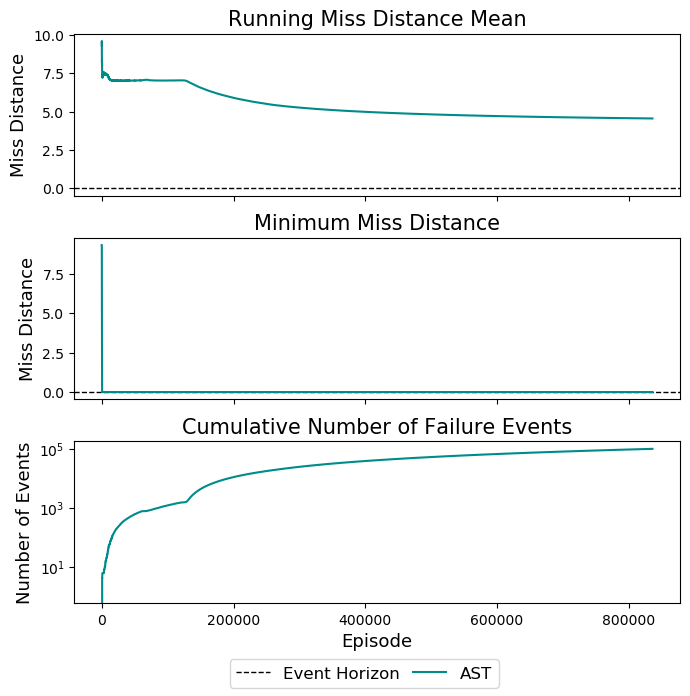

In [19]:
episodic_figures(planner.mdp.metrics; gui=false)

### Distribution plots
Plots miss distance distribution and log-likelihood distribution.

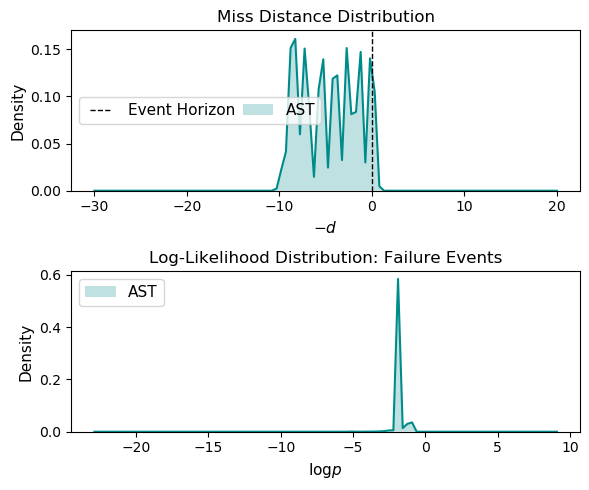

In [20]:
distribution_figures(planner.mdp.metrics; gui=false)